# Image Reshaping
* Experiment with converting an image into separate 1D vectors and then passing thru SegmentNet layers to train / predict

# Initialization

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Image Dataset

## Download MNIST

In [4]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_set = datasets.MNIST('data', train=True, download=False, transform=transform)

In [5]:
# get 1st image
index = 2
# Get the image and its corresponding label
image, label = train_set[index]

torch.Size([1, 28, 28])


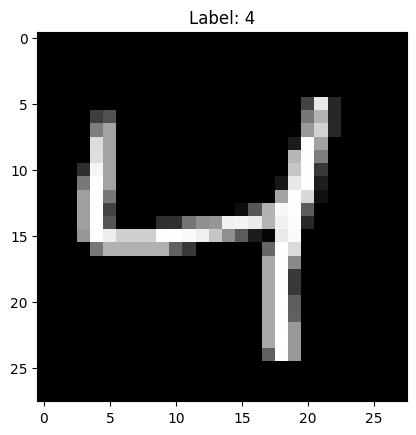

In [6]:
# display MNST image
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

torch.Size([28, 28])


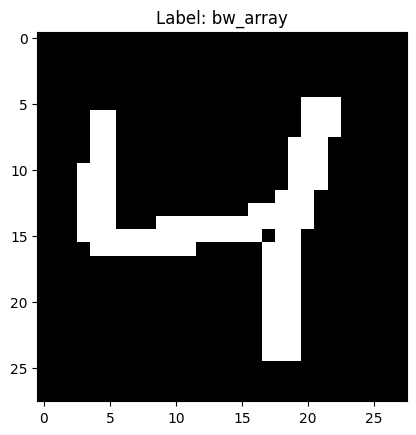

In [7]:
# Let us convert the image to BW image (atleast for this dataset)

def get_bw_array(image):
    test_image = image.squeeze().numpy() #[0:20,:] #or reshape if needed for testing
    limit = test_image.mean()
    bw_array  = torch.tensor(np.where(test_image < limit, 0, 1))
    return bw_array

bw_array = get_bw_array(image)
#display bw_array
print(bw_array.shape)
plt.imshow(bw_array, cmap='gray')
plt.title(f"Label: bw_array")
plt.show()

## Image flattening experiments

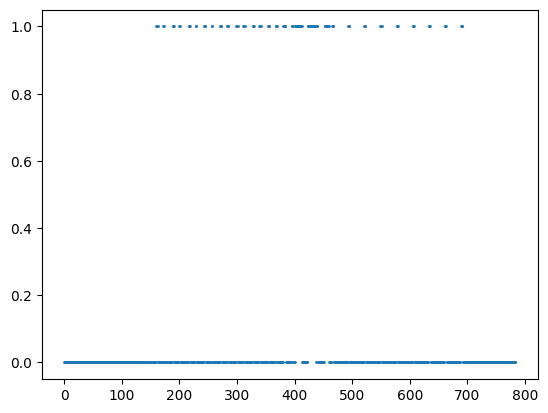

In [13]:
# To flatten 2D image to 1D by row
row_wise = torch.flatten(bw_array)
x = torch.arange(row_wise.shape[0])
y = row_wise.data
plt.scatter(x, y, s=1) #not very interesting

(28, 1)


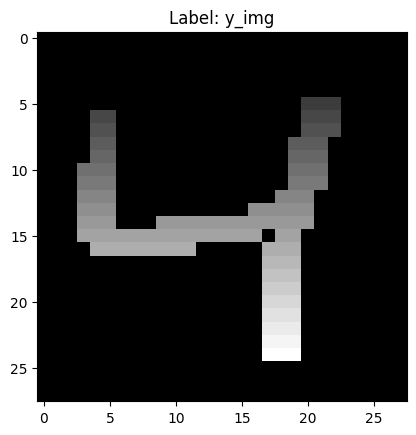

In [9]:
# the above image is not interesting as it only has 0 or 1 values
# let us replace 1 values with column height
# we start arange from 1 as we want to differentiate between no value and 1st row value
y_val = np.arange(1,bw_array.shape[0]+1)
y_val = y_val.reshape(y_val.shape[0],1)
print(y_val.shape)
y_img = bw_array*y_val

#Verify that y_val is same for every horizontal line
plt.imshow(y_img, cmap='gray')
plt.title(f"Label: y_img")
plt.show()

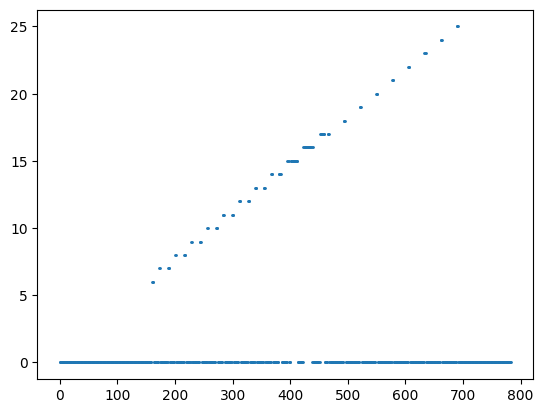

In [29]:
row_wise = y_img.flatten()
x = torch.arange(row_wise.shape[0])
y = row_wise.data #position on y * intensity (1)
plt.scatter(x, y, s=1) # Looks trainable 

In [20]:
for i in range(x.data.shape[0]):
    print(x.data[i].item(),y.data[i].item())


0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 6
161 6
162 6
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 7
173 7
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0


(28,)


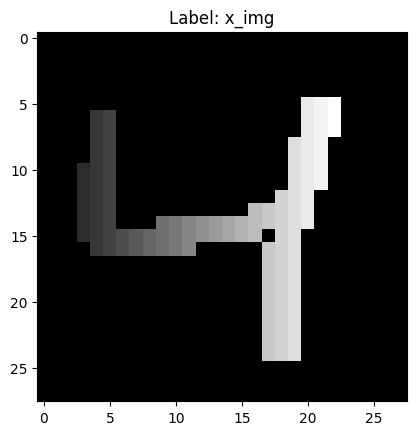

In [22]:
# Let us try column wise
# let us replace 1 values with row width
# we start arange from 1 as we want to differentiate between no value and 1st column value
x_val = np.arange(1,bw_array.shape[0]+1)
print(x_val.shape)
x_img = bw_array*x_val

#Verify that y_val is same for every horizontal line
plt.imshow(x_img, cmap='gray')
plt.title(f"Label: x_img")
plt.show()

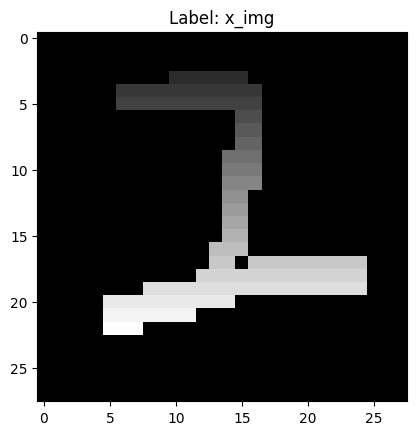

In [26]:
# To Column-wise Flatten, we first rotate the image 90 degrees
plt.imshow(x_img.permute(1,0), cmap='gray')
plt.title(f"Label: x_img")
plt.show()

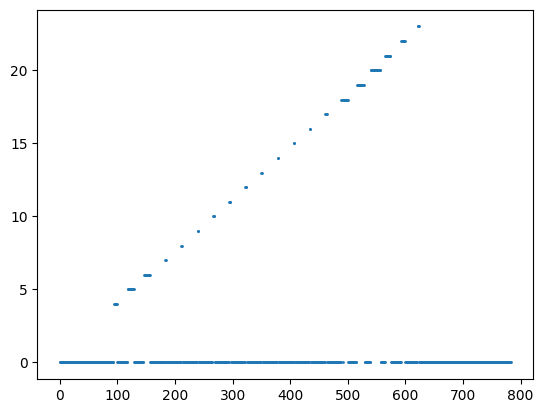

In [34]:
# now we can flatten column-wise
col_wise = x_img.permute(1,0).flatten()
x = torch.arange(col_wise.shape[0])
y = col_wise.data #position on y * intensity (1)
plt.scatter(x, y, s=1) # Looks trainable and different than row_wise

## Image Flattening Function

In [35]:
# Create function that returns x,y for an image
def flatten_image(image, row_wise=True):
    if row_wise:
        columns = np.arange(1,image.shape[0]+1)
        # reshape the image only for row_wise so product works
        columns = columns.reshape(y_val.shape[0],1)
        # Create an image that contains y_position info along with color depth
        y_img = image*columns
        #flatten the image to get x, y
        row_wise_data = y_img.flatten()
        x = torch.arange(row_wise_data.shape[0]) # row wise sequence of data
        y = row_wise_data # row location from 1:N multipled by color depth. 
        # NOTE: data is not normalized. 
        return x, y, y_img
    else:
        rows = np.arange(1,image.shape[1]+1)
        x_img = image*rows #No need to reshape for col_wise
        # We need to rotate the image by 90 degrees to flatten it by column
        col_wise_data = x_img.permute(1,0).flatten()
        x = torch.arange(col_wise_data.shape[0])
        y = col_wise_data
        return x, y, x_img

### Test function

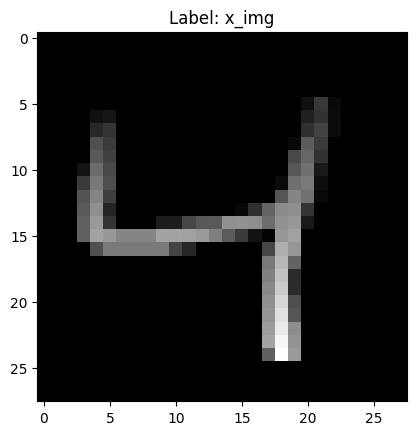

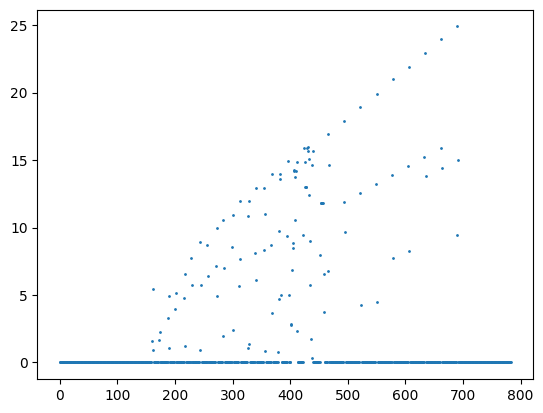

In [40]:
# flatten by row
x, y, newimg = flatten_image(image.squeeze())
plt.imshow(newimg, cmap='gray')
plt.title(f"Label: x_img")
plt.show()
plt.scatter(x, y, s=1)

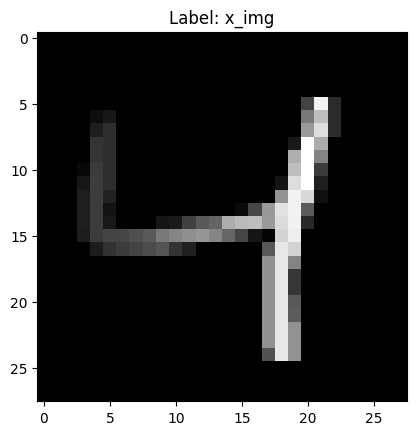

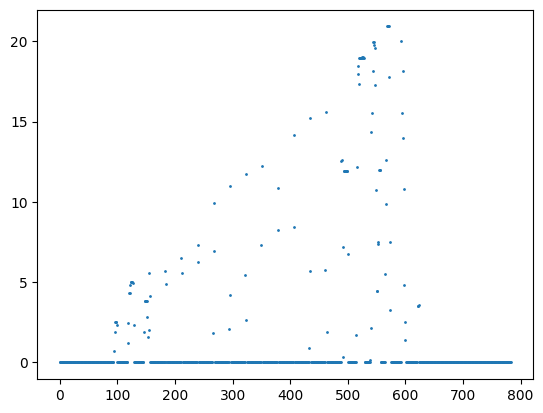

In [41]:
# flatten by col
x, y, newimg = flatten_image(image.squeeze(),row_wise=False)
plt.imshow(newimg, cmap='gray')
plt.title(f"Label: x_img")
plt.show()
plt.scatter(x, y, s=1)

# Train a segmentNet for row_wise and column_wise data
* experiment with two separate nets and one combined net